In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import random

#for reproducibility
random.seed(99)
np.random.seed(99)

%pip install keras-tqdm -q

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/clapDetector_speaker/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/clapDetector_speaker


In [0]:
claps1 = np.load("claps1.npy")
claps2 = np.load("claps2.npy")
claps = np.concatenate((claps1, claps2),axis=0)
%reset_selective -f "claps1"
%reset_selective -f "claps2"

In [0]:
import numpy as np

urban8k = np.load("urban8k_selected.npy")
urban8k_labels = np.load("urban8k_selected_labels.npy")
urban8k_labels_sortind = np.argsort(urban8k_labels[:,0])
urban8k_labels = urban8k_labels[urban8k_labels_sortind]
urban8k = urban8k[urban8k_labels_sortind]
unique, counts = np.unique(urban8k_labels, return_counts=True) #remove false "9" labels
urban8k_labels = urban8k_labels[:-counts[-1],:]
urban8k = urban8k[:-counts[-1],:]
unique, counts = np.unique(urban8k_labels, return_counts=True)

In [0]:
claps_l = claps.shape[0]
#split urban8k
split_indices = np.cumsum(counts)
classes = np.split(urban8k, split_indices[:-1])
train_x = np.zeros((urban8k.shape),dtype=np.float)
train_y = np.zeros((urban8k.shape[0],1),dtype=np.int)

cnt_train = 0
cnt_test = 0
class_label = 0
for class_ in classes:
  for j in range(class_.shape[0]):
    train_x[cnt_train] = class_[j,:]
    train_y[cnt_train] = class_label
    cnt_train = cnt_train+1
  class_label = class_label+1

train_x = np.concatenate((train_x, claps), axis=0)
train_y = np.concatenate((train_y, class_label*np.ones((claps_l,1),dtype=np.int)), axis=0)

train_x, test_x, train_y, test_y = train_test_split(train_x,train_y,test_size=0.2,random_state=99)
train_x, val_x, train_y, val_y = train_test_split(train_x,train_y,test_size=0.125,random_state=99)

In [0]:
#convert to spectrograms
#pass urbansound8k samples through reverse mode simulations 
#convert to mel-spectrograms

#sampling rate, FFT length, hop-length for the sliding window 
sr = 44100
n_fft = 512
hl = n_fft//4
spectr_rows = n_fft//2+1

#test conversion to get params
D = librosa.amplitude_to_db(np.abs(librosa.stft(train_x[0],n_fft=n_fft, hop_length=hl)),ref=np.max)
spectr_cols = D.shape[1]

#get speaker transfer function: 2" speaker, resonance frequency=270Hz
tf = np.load("transferfunction_smallSpeaker.npy")

#input format for the neural network
output_rows = 64
output_cols = spectr_cols

split_ids_tf = np.linspace(0,sr//4,spectr_rows+1,dtype=np.int)[1:-1]
tf_parts = np.split(tf, split_ids_tf)
split_maxs = [np.mean(j) for j in tf_parts]

tf_rs = split_maxs
tf_rs = np.asarray(tf_rs)
tf_rs = tf_rs.reshape((-1,1))
#reverse mode simulation mask
tf_img = np.tile(tf_rs, (1,output_cols))

#2D containers for mel-spectrograms
train_x_2D = np.zeros( (train_x.shape[0], output_rows, output_cols, 1) , dtype=np.float)
test_x_2D = np.zeros( (test_x.shape[0], output_rows, output_cols, 1) , dtype=np.float)
val_x_2D = np.zeros( (val_x.shape[0], output_rows, output_cols, 1) , dtype=np.float)

#raw audio -> spectrogram -> reverse mode simualtion (spectrogram * mask) -> mel-spectrogram
for i in range(train_x.shape[0]):
  train_x_2D[i,:,:,0] = librosa.feature.melspectrogram(y=None, sr=sr, S=librosa.amplitude_to_db(np.abs(librosa.stft(train_x[i],n_fft=n_fft, hop_length=hl))[:,:]*tf_img, ref=np.max), n_fft=n_fft, hop_length=hl, n_mels=output_rows, fmin=0, fmax=sr//2)
for i in range(test_x.shape[0]):
  test_x_2D[i,:,:,0] = librosa.feature.melspectrogram(y=None, sr=sr, S=librosa.amplitude_to_db(np.abs(librosa.stft(test_x[i],n_fft=n_fft, hop_length=hl))[:,:]*tf_img, ref=np.max), n_fft=n_fft, hop_length=hl, n_mels=output_rows, fmin=0, fmax=sr//2)
for i in range(val_x.shape[0]):
  val_x_2D[i,:,:,0] = librosa.feature.melspectrogram(y=None, sr=sr, S=librosa.amplitude_to_db(np.abs(librosa.stft(val_x[i],n_fft=n_fft, hop_length=hl))[:,:]*tf_img, ref=np.max), n_fft=n_fft, hop_length=hl, n_mels=output_rows, fmin=0, fmax=sr//2)

#normalize input
train_x_2D = train_x_2D - np.mean(train_x_2D)
train_x_2D = train_x_2D / np.std(train_x_2D)
test_x_2D = test_x_2D - np.mean(test_x_2D)
test_x_2D = test_x_2D / np.std(test_x_2D)
val_x_2D = val_x_2D - np.mean(val_x_2D)
val_x_2D = val_x_2D / np.std(val_x_2D)

Model implementation:

The model was published in https://github.com/douglas125/SpeechCmdRecognition

[Coimbra de Andrade et al.(2018)]{2018arXiv180808929C} Coimbra de Andrade, D., Leo, S., Loesener Da Silva Viana, M., Bernkopf, C.\ 2018.\ A neural attention model for speech command recognition.\ arXiv e-prints arXiv:1808.08929.


In [0]:
from keras.models import Model, load_model

from keras.layers import Input, Activation, Concatenate, Permute, Reshape, Flatten, Lambda, Dot, Softmax
from keras.layers import Add, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D, Dense, CuDNNLSTM, Bidirectional
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import optimizers

num_of_classes = 6

inputs = Input((output_rows,output_cols,1))

x = Reshape((output_rows, output_cols, 1)) (inputs)

#note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
#we would rather have it the other way around for LSTMs

x = Permute((2,1,3)) (x)

x = Conv2D(10, (5,1) , activation='relu', padding='same') (x)
x = BatchNormalization() (x)
x = Conv2D(10, (5,1) , activation='relu', padding='same') (x)
x = BatchNormalization() (x)
x = Conv2D(1, (5,1) , activation='relu', padding='same') (x)
x = BatchNormalization() (x)

#x = Reshape((125, 80)) (x)
x = Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim') (x) #keras.backend.squeeze(x, axis)

x = Bidirectional(CuDNNLSTM(64, return_sequences = True)) (x) # [b_s, seq_len, vec_dim]
x = Bidirectional(CuDNNLSTM(64, return_sequences = True)) (x) # [b_s, seq_len, vec_dim]

xFirst = Lambda(lambda q: q[:,64]) (x) #[b_s, vec_dim]
query = Dense(128) (xFirst)

#dot product attention
attScores = Dot(axes=[1,2])([query, x]) 
attScores = Softmax(name='attSoftmax')(attScores) #[b_s, seq_len]

#rescale sequence
attVector = Dot(axes=[1,1])([attScores, x]) #[b_s, vec_dim]

x = Dense(64, activation = 'relu')(attVector)
x = Dense(32)(x)

#the original code changes here, because we have 6 classes
output = Dense(num_of_classes, activation = 'softmax', name='output')(x)
model = None
model = Model(inputs=[inputs], outputs=[output])
#print model architecture
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 64, 65, 1)    0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 64, 65, 1)    0           input_5[0][0]                    
__________________________________________________________________________________________________
permute_5 (Permute)             (None, 65, 64, 1)    0           reshape_5[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 65, 64, 10)   60          permute_5[0][0]                  
____________________________________________________________________________________________

In [0]:
from keras import optimizers
from keras_tqdm import TQDMNotebookCallback
import math
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.utils import class_weight

#compute class weights (the dataset in imbalanced)
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y[:,0])
#Learning rate control based on the progress of the training process
#source: https://github.com/douglas125/SpeechCmdRecognition
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

#set callback handlers
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-attRNN_u8k_paper.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

#compile model: adam optimizer
model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
print('# Fit model on training data')
#set batch size and max number of epochs
#start training
results = model.fit(train_x_2D, train_y, validation_data = (val_x_2D, val_y), batch_size=8, epochs = 60, use_multiprocessing=True, workers=4, verbose=1,
                     callbacks=[earlystopper, lrate, TQDMNotebookCallback()], shuffle=True, class_weight=class_weights)
#print history
#print('\nhistory dict:', results.history)
model.save("clapdetector_sample.h5")

# Fit model on training data
Train on 2924 samples, validate on 418 samples


Epoch 1/60
Changing learning rate to 0.001


2924/2924 [==============================] - 14s 5ms/step - loss: 1.0123 - sparse_categorical_accuracy: 0.6194 - val_loss: 0.8029 - val_sparse_categorical_accuracy: 0.7081
Epoch 2/60
Changing learning rate to 0.001


2924/2924 [==============================] - 9s 3ms/step - loss: 0.5913 - sparse_categorical_accuracy: 0.7917 - val_loss: 0.4689 - val_sparse_categorical_accuracy: 0.8182
Epoch 3/60
Changing learning rate to 0.001


2924/2924 [==============================] - 9s 3ms/step - loss: 0.4578 - sparse_categorical_accuracy: 0.8417 - val_loss: 0.6197 - val_sparse_categorical_accuracy: 0.7823
Epoch 4/60
Changing learning rate to 0.001


2924/2924 [==============================] - 9s 3ms/step - loss: 0.3958 - sparse_categorical_accuracy: 0.8615 - val_loss: 0.4314 - val_sparse_categorical_accuracy: 0.8636
Epoch 5/60
Changing learning rate to 0.001


2924/2924 [==============================] - 9s 3ms/step - loss: 0.3617 - sparse_categorical_accuracy: 0.8806 - val_loss: 0.4455 - val_sparse_categorical_accuracy: 0.8469
Epoch 6/60
Changing learning rate to 0.001


2924/2924 [==============================] - 9s 3ms/step - loss: 0.3012 - sparse_categorical_accuracy: 0.9060 - val_loss: 0.3810 - val_sparse_categorical_accuracy: 0.8828
Epoch 7/60
Changing learning rate to 0.001


2924/2924 [==============================] - 9s 3ms/step - loss: 0.2954 - sparse_categorical_accuracy: 0.8998 - val_loss: 0.3500 - val_sparse_categorical_accuracy: 0.8804
Epoch 8/60
Changing learning rate to 0.001


2924/2924 [==============================] - 9s 3ms/step - loss: 0.2633 - sparse_categorical_accuracy: 0.9135 - val_loss: 0.3748 - val_sparse_categorical_accuracy: 0.8828
Epoch 9/60
Changing learning rate to 0.001


2924/2924 [==============================] - 9s 3ms/step - loss: 0.2179 - sparse_categorical_accuracy: 0.9282 - val_loss: 0.4560 - val_sparse_categorical_accuracy: 0.8541
Epoch 10/60
Changing learning rate to 0.0004


2924/2924 [==============================] - 9s 3ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.9583 - val_loss: 0.3148 - val_sparse_categorical_accuracy: 0.8995
Epoch 11/60
Changing learning rate to 0.0004


2924/2924 [==============================] - 9s 3ms/step - loss: 0.0877 - sparse_categorical_accuracy: 0.9713 - val_loss: 0.3658 - val_sparse_categorical_accuracy: 0.8947
Epoch 12/60
Changing learning rate to 0.0004


2924/2924 [==============================] - 9s 3ms/step - loss: 0.0779 - sparse_categorical_accuracy: 0.9757 - val_loss: 0.3649 - val_sparse_categorical_accuracy: 0.9067
Epoch 13/60
Changing learning rate to 0.0004


2924/2924 [==============================] - 9s 3ms/step - loss: 0.0499 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.3810 - val_sparse_categorical_accuracy: 0.9091
Epoch 14/60
Changing learning rate to 0.0004


2924/2924 [==============================] - 9s 3ms/step - loss: 0.0348 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.4205 - val_sparse_categorical_accuracy: 0.8900
Epoch 15/60
Changing learning rate to 0.0004


2924/2924 [==============================] - 9s 3ms/step - loss: 0.0642 - sparse_categorical_accuracy: 0.9774 - val_loss: 0.3714 - val_sparse_categorical_accuracy: 0.9163
Epoch 16/60
Changing learning rate to 0.0004


2924/2924 [==============================] - 9s 3ms/step - loss: 0.0578 - sparse_categorical_accuracy: 0.9836 - val_loss: 0.4805 - val_sparse_categorical_accuracy: 0.8684
Epoch 17/60
Changing learning rate to 0.0004


2924/2924 [==============================] - 9s 3ms/step - loss: 0.0563 - sparse_categorical_accuracy: 0.9839 - val_loss: 0.4307 - val_sparse_categorical_accuracy: 0.8876
Epoch 18/60
Changing learning rate to 0.0004


2924/2924 [==============================] - 9s 3ms/step - loss: 0.0388 - sparse_categorical_accuracy: 0.9880 - val_loss: 0.4458 - val_sparse_categorical_accuracy: 0.8923
Epoch 19/60
Changing learning rate to 0.0004


2924/2924 [==============================] - 9s 3ms/step - loss: 0.0323 - sparse_categorical_accuracy: 0.9897 - val_loss: 0.4603 - val_sparse_categorical_accuracy: 0.9067
Epoch 20/60
Changing learning rate to 0.00016000000000000004


2924/2924 [==============================] - 9s 3ms/step - loss: 0.0082 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.4410 - val_sparse_categorical_accuracy: 0.9163
Epoch 00020: early stopping


In [0]:
result = model.evaluate(test_x_2D, test_y, batch_size=1)
print(result)

836/836 [==============================] - 6s 8ms/step
[0.44292944725404715, 0.9126794258373205]


In [0]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(test_x_2D)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
# print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Car horn', 'Dog bark', 'Gunshot', 'Jackhammer', 'Siren', 'Claps']
print(classification_report(test_y, y_pred, target_names=target_names))

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

    Car horn       0.93      0.80      0.86        88
    Dog bark       0.91      0.85      0.88       203
     Gunshot       0.95      0.95      0.95        73
  Jackhammer       0.86      0.99      0.92       179
       Siren       0.90      0.92      0.91       190
       Claps       1.00      0.97      0.99       103

    accuracy                           0.91       836
   macro avg       0.93      0.91      0.92       836
weighted avg       0.92      0.91      0.91       836



Claps


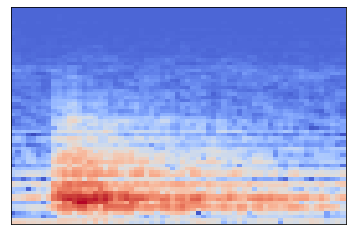

Jackhammer


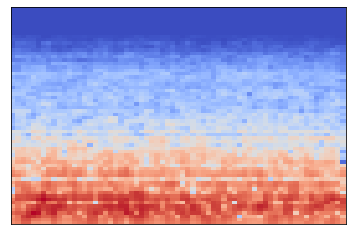

Dog bark


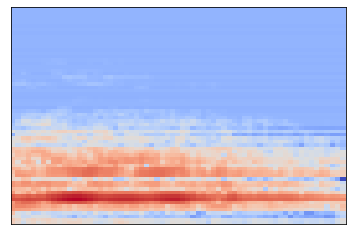

In [0]:
id = 130
librosa.display.specshow(train_x_2D[id,:,:,0],sr=sr)
print(target_names[train_y[id,0]])
plt.show()
librosa.display.specshow(train_x_2D[id+1,:,:,0],sr=sr)
print(target_names[train_y[id+1,0]])
plt.show()
librosa.display.specshow(train_x_2D[id+2,:,:,0],sr=sr)
print(target_names[train_y[id+2,0]])
plt.show()

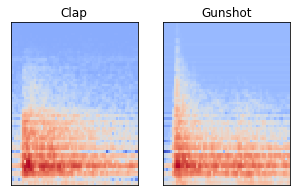

In [0]:
#figure for the paper
# clap_id = 600
# gunshot_id = 60
# plt.figure(figsize=(5,3))
# plt.subplot(1,2,1)
# librosa.display.specshow(train_x_2D[clap_id,:,:,0],sr=sr)
# plt.title('Clap')
# plt.subplot(1,2,2)
# librosa.display.specshow(train_x_2D[gunshot_id,:,:,0],sr=sr)
# plt.title('Gunshot')
# plt.savefig("spectr_comparison.pdf")
# plt.show()

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

cfm = metrics.confusion_matrix(test_y, y_pred)


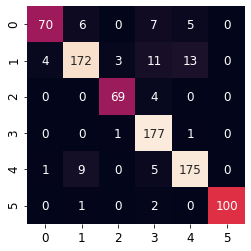

In [0]:
import seaborn as sns
sns.heatmap(cfm, annot=True, fmt='d', cbar=False, square=True)

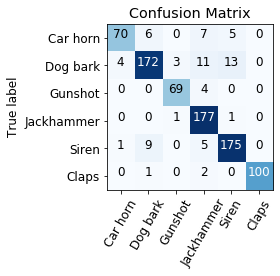

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=60)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('cfm_clapdetector.pdf',bbox_inches='tight')
    plt.show()


plot_confusion_matrix(cm           = cfm, 
                      normalize    = False,
                      target_names = target_names,
                      title        = "Confusion Matrix")